# IAS Project 2 Development Notebook

This is the working notebook for development on IAS Project 2. All intermittent steps, experimental plots, etc used in developing and training an HMM for gesture recognition are here.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import pickle as pkl
from IPython.core.debugger import set_trace

In [ ]:
from sklearn.cluster import KMeans

## HMM Filtering
### Forward Filter

In [ ]:
def forward_filt(A, B, pi, obs):
    K = len(obs) #number of observations
    S = len(A) #number of states
    #q_ki = P(s_k = i, y_1:k)
    alpha = np.zeros((K,S))
    scale_factor = np.zeros(K)

    #initialization
    alpha[0] = np.multiply(B[:,obs[0]],pi) #4x1 vector  
    scale_factor[0] = 1/np.maximum(1e-300,np.sum(alpha[0]))
    alpha[0] *= scale_factor[0] #normalizen

    for k in range(1,len(obs)):
        B_k = np.diag(B[:,obs[k]])
        alpha[k] = np.dot(np.dot(B_k,A.T),alpha[k-1]) #P(j,o..) = P(i,o..)P(j|i)P(o|j)
        #alpha[k][alpha[k] == 0] = 1e-10
        scale_factor[k] = 1/np.maximum(1e-300,np.sum(alpha[k]))
        alpha[k] = alpha[k] * scale_factor[k] #normalize

    # #Equivalent For Loop
    # for k in range(1,len(obs)):
    #     for j in range(len(A)):
    #         for i in range(len(A)):
    #             alpha[k,j] += alpha[k-1,i]*A[i,j]*B[j,obs[k]]
    #     scale_factor[k] = 1/np.sum(alpha[k])
    #     alpha[k] = alpha[k] * scale_factor[k]

    return [alpha, scale_factor]

### Backward Filter

In [ ]:
def backward_filt(A, B, obs, scale_factor):
    nstates = len(A)
    K = len(obs)
    beta = np.zeros((K,nstates))
    #initialization
    beta[K-1] = np.ones(nstates)
    beta[K-1][beta[K-1] == 0] = 1e-10
    #beta[K-1] = beta[K-1]/len(A)
    beta[K-1] *= scale_factor[0]
    for k in range(K-1,0,-1):
        B_k = np.diag(B[:,obs[k]]) #diagonalize for elementwise multiplication w/ dot prod
        beta[k-1] = np.dot(np.dot(A,B_k),beta[k]) #beta[k-1] = A * B_k * beta[k]
        beta[k-1] *= scale_factor[k-1]
        #beta[k-1] = beta[k-1]/np.maximum(1e-300,np.sum(beta[k-1]))

    # #Equivalent For Loop
    # for k in range(K-1,0,-1):
    #     for i in range(nstates):
    #         for j in range(nstates):
    #             beta[k-1,i]  += beta[k,j]*B[j,obs[k]]*A[i,j]
    #     beta[k-1] = beta[k-1] * scale_factor[K-k]
    return beta


In [ ]:
def forward_backward(features, A, B, pi):
	T = features.shape[0]
	N = A.shape[0]

	coeff = np.zeros((T, 1))

	alpha = np.zeros((T, N))
	alpha[0] = pi[:, 0] * B[features[0]]
	coeff[0] = 1. / np.maximum(1E-10, np.sum(alpha[0]))
	alpha[0] *= coeff[0]

	# Forward
	for t in range(0, T-1):
		alpha[t+1] = np.sum(alpha[t][:, np.newaxis] * A, axis=0) * B[features[t+1]]
		coeff[t+1] = 1. / np.maximum(1E-10, np.sum(alpha[t+1]))
		alpha[t+1] *= coeff[t+1]
		alpha[t+1] = np.clip(alpha[t+1], a_min=1E-100, a_max=1)

	P_0 = -np.sum(np.log(coeff))

	beta = np.zeros((T, N))
	beta[-1] = 1
	beta[-1] *= coeff[-1]

	# Backward
	for t in range(T-2, -1, -1):
		beta[t] = np.sum(A * B[features[t+1]][np.newaxis, :] * beta[t+1][np.newaxis, :], axis=1)
		beta[t] *= coeff[t]

	return alpha, beta, P_0, coeff

### Smoother

In [ ]:
def smoother(alpha, beta):
    K = len(alpha) #number of observations/time steps
    gamma = np.zeros(alpha.shape)

    for k in range(K):
        alpha_k = alpha[k]
        beta_k = beta[k]
        num = np.multiply(alpha_k, beta_k)
        den = np.sum(num) #sum across all states
        #gamma[k] /= scale_factor[k]
        gamma[k] = num/np.maximum(1e-300,den) #normalize

    # #Equivalent For Loop
    # for k in range(K):
    #     for i in range(alpha.shape[1]):
    #         gamma[k,i] = alpha[k,i] * beta[k,i]
    #     gamma[k] = gamma[k]/np.sum(gamma[k])
    return gamma

### Combined Optimal HMM Filter Function

In [ ]:
def HMM_filter(A, B, pi, obs):
    alpha, c = forward_filt(A, B, pi, o)
    beta = backward_filt(A, B, o, c)
    gamma = smoother(alpha, beta)
    return gamma

### Paired States

In [ ]:
def paired_st(A, B, alpha, beta, obs):
    K = len(alpha) #number of observations
    S = len(A) #number of states
    xi = np.zeros([K,S,S])
    for k in range(K):
        alpha_k = alpha[k,:,np.newaxis] #add new axis so mmultiplication will work elementwize
        beta_k1 = beta[(k+1)%K,:]
        o_k1 = obs[(k+1)%K] #next observation (loop around to start for last obs)
        B_k1 = B[:,o_k1] #likelihood of next observation for given state

        xi[k] = alpha_k * A * B_k1 * beta_k1
        # xi[k][xi[k] == 0] = 1e-10
        xi[k] = xi[k]/np.maximum(1e-300,np.sum(xi[k])) #normalize

        # #Equivalent For Loop
        # for i in range(S):
        #     for j in range(S):
        #         xi[k,i,j] = alpha[k,i]*A[i,j]*B_k1[j]*beta_k1[j]
        # xi[k] = xi[k]/np.sum(xi[k]) #normalize
    return xi

## Simulate toy Markov Chain to test filters

In [ ]:
def sim_MC(A, B, pi, K):
    s = np.zeros(K,dtype=np.uint8) #vector of samples
    o = np.zeros(K,dtype=np.uint8) #vector of observations
    s[0] = np.random.choice(len(A), 1, p=pi) #sim initial state
    for k in range(1,K):
        s[k] = np.random.choice(len(A), 1, p=A[s[k-1]]) #sim next state
        o[k] = np.random.choice(B.shape[1], 1, p=B[s[k]]) #sim observation
    return [s, o]

In [ ]:
K = 200

#3 possible states, 5 possible observations
pi = [0.2, 0.6, 0.2]
pi = np.array(pi)

# sj   0    1    2  | si
A = [[0.8, 0.2, 0.0], #0
     [0.1, 0.7, 0.2], #1
     [0.3, 0.0, 0.7]] #2
A = np.array(A)

# ok   0    1    2    3    4  | sk
B = [[0.50, 0.30, 0.10, 0.05, 0.05], #0
     [0.05, 0.20, 0.50, 0.20, 0.05], #1
     [0.05, 0.05, 0.10, 0.30, 0.50]] #s
B = np.array(B)

s,o = sim_MC(A, B, pi, K)

### Run filters on toy MC

In [ ]:
alpha, c = forward_filt(A, B, pi, o) #forward filter probabilities
beta = backward_filt(A, B, o, c) #backward filter probabilities
gamma = smoother(alpha, beta) #combined probabilities

In [ ]:
alpha_1, beta_1, _, c_1 = forward_backward(o,A,B.T,pi[:,np.newaxis])

In [ ]:
#for discrete state estimates, take argmax of state probabilities
# a_est = np.dot(alpha,range(3)) #forward filter state estimates
# b_est = np.dot(beta,range(3)) #backward filter state estimates
# g_est = np.dot(gamma,range(3)) #optimal combined state estimates

a1_est = np.argmax(alpha_1,axis=1)
b1_est = np.argmax(beta_1,axis=1)

a_est = np.argmax(alpha,axis=1)
b_est = np.argmax(beta,axis=1)
g_est = np.argmax(gamma,axis=1)

In [ ]:
#plt.plot(s); #plot true state
plt.plot(np.round(o/2)) #plot naive estimate from observations
plt.plot(a_est); #plot forward filter estimate
# plt.plot(b_est) #plot backward filter estimate
# plt.plot(g_est) #plot optimal combined estimate
plt.legend(['true state', 'filt']);# 'obs', 'filt'])#, 'backward', 'combined'])
plt.title('Comparisson of State Estimates')
plt.grid(True,markevery=1)

### Compare mean-squared errors of each filter

In [ ]:
mse_obs = np.mean(((s - np.round(o/2))**2))
mse_a_est = np.mean(((s - a_est)**2))
mse_b_est = np.mean(((s - b_est)**2))
mse_g_est = np.mean(((s - g_est)**2))
print('obs mse:\t', mse_obs)
print('fwd mse:\t', mse_a_est)
print('bkwd mse:\t', mse_b_est)
print('opt mse:\t', mse_g_est)

In [ ]:
mse_a1_est = np.mean(((s - a1_est)**2))
mse_b1_est = np.mean(((s - b1_est)**2))
# mse_g_est = np.mean(((s - g_est)**2))
# print('obs mse:\t', mse_obs)
print('fwd mse:\t', mse_a1_est)
print('bkwd mse:\t', mse_b1_est)
# print('opt mse:\t', mse_g_est)

In [ ]:
c[0:20]

### Check that Paired States Function returns correct size and probs sum to 1

In [ ]:
xi = paired_st(A, B, alpha, beta, o)
xi.shape == (len(alpha),) + A.shape #check that returned shape is as expected

In [ ]:
prop_sums = np.sum(xi,axis=(1,2)) #sum across all i,j for each observation
is_ones = np.round(prop_sums,5) == 1 #compare sums to one, rounding to 5 decimals
np.all(is_ones) #check that all probabilities sum to one

## Try running functions on some of our observations

# Baum Welsch Algorithm

In [94]:
def baum_welsch(HMM, obs, N): #(initial guesses,,, observations, number of iterations)
    A_est = np.copy(HMM[0])
    B_est = np.copy(HMM[1])
    pi_est = np.copy(HMM[2])
    K = len(obs) #number of observations
    S = len(A_est) #number of states
    O = B_est.shape[1] #number of observation states
    l = np.zeros(N) #likelihoods
    for n in range(N):
        #E-Step---------------
        #HMM Filtering
        #---------------------
        alpha, c = forward_filt(A_est, B_est, pi_est, obs) #run forward filter
        beta = backward_filt(A_est, B_est, obs, c) #run backward filter
        gamma = smoother(alpha, beta) #run smoother
        xi = paired_st(A_est, B_est, alpha, beta, obs)

        l[n] = -np.sum(np.log(c))

        # print('Max Vals')
        # print('-----------------')
        # print('Alpha',np.max(alpha))
        # print('Scale',np.max(c))
        # print('Beta',np.max(beta))
        # print('Gamma',np.max(gamma))
        # print('Xi',np.max(xi))
        # print()

        #M-Step---------------
        #update parameter estimates
        #---------------------
        #update pi_est
        pi_est = gamma[0]
        
        #update A_est
        A_num = np.sum(xi,axis=0) #expected num of jumps from i to j
        A_den = np.sum(gamma,axis=0)[:,np.newaxis] #total expected visits to i
        A_est = A_num/np.maximum(1e-10,A_den)

        #update B_est
        B_den = np.sum(gamma,axis=0)
        #B_den[B_den == 0] = 1e-10
        for o in range(B_est.shape[1]): #loop through all possible observations
            B_num = np.sum(gamma[obs == o],axis=0) #sum over observations o 
            B_est[:,o] = B_num/np.maximum(1e-10,B_den)

        # #Equivalent For Loop
        # for i in range(S): #current state
        #     for j in range(S): #next state
        #         A_num = np.sum(xi[:,i,j])
        #         A_den = np.sum(gamma[:,i])
        #         A_est[i,j] = A_num/np.maximum(1e-10,A_den)
        #     for o in range(O): #observation state
        #         B_num = 0
        #         for k in range(K): #observation
        #             if(obs[k] == o):
        #                 B_num += gamma[k,i]
        #         B_den = np.sum(gamma[:,i])
        #         B_est[i,o] = B_num/np.maximum(1e-10,B_den)
    return [A_est, B_est, pi_est, l]

### Test Baum Welsch on toy MC

In [95]:
#generate random probability matrix (rows sum to 1)
def rand_prob_mat(shape):
    p = np.zeros(shape)
    nrows = shape[0]
    if(len(shape) == 1):
        p = np.random.rand(nrows)
        p = p/np.sum(p)
    elif(len(shape) == 2):
        ncols = shape[1]
        for i in range(nrows):
            p[i,:] = np.random.rand(1,ncols)
            p[i,:] = p[i,:]/np.sum(p[i,:])
    return p

In [98]:
np.random.seed(40)
s1,o1 = sim_MC(A, B, pi, 300) #simulate a Markov Chain with 200 obs

#generate random guesses for A, B, pi
A_est = rand_prob_mat(A.shape)
B_est = rand_prob_mat(B.shape)
pi_est = rand_prob_mat(pi.shape)
HMM_est = [A_est, B_est, pi_est]

#estimate A, B, pi using baum welsch algorithm
A_est, B_est, pi_est, l = baum_welsch(HMM_est, o1, 40)

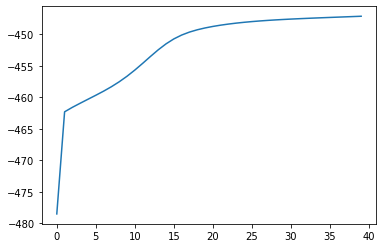

In [99]:
plt.plot(l)

In [100]:
#Find MSE of baum welsch estimates from true state
A_mse_bw = ((A_est - A)**2).mean()
B_mse_bw = ((B_est - B)**2).mean()
pi_mse_bw = ((pi_est - pi)**2).mean()

A_mse_N = ((1/A.shape[1] - A)**2).mean()
B_mse_N = ((1/B.shape[1] - B)**2).mean()
pi_mse_N = ((1/len(pi) - pi)**2).mean()

#Find MSE of mean from true state (equivalent to variance)
# A_mse_ig = np.var(A)
# B_mse_ig = np.var(B)
# pi_mse_ig = np.var(pi)

print('Baum Welsch')
print('---------------------------- ')
print('A MSE:\t', A_mse_bw)
print('B MSE:\t', B_mse_bw)
print('pi MSE:\t', pi_mse_bw)
print()
print('Naive (Uniform)')
print('----------------------------')
print('A MSE:\t', A_mse_N)
print('B MSE:\t', B_mse_N)
print('pi MSE:\t', pi_mse_N)

Baum Welsch
---------------------------- 
A MSE:	 0.08138860046842779
B MSE:	 0.04681567263113058
pi MSE:	 0.34666664845220185

Naive (Uniform)
----------------------------
A MSE:	 0.08888888888888889
B MSE:	 0.02966666666666667
pi MSE:	 0.03555555555555555


In [101]:
A

array([[0.8, 0.2, 0. ],
       [0.1, 0.7, 0.2],
       [0.3, 0. , 0.7]])

In [102]:
A_est

array([[0.42413949, 0.29019551, 0.28568767],
       [0.55645401, 0.3918813 , 0.05180848],
       [0.03015464, 0.31793163, 0.65174598]])

# Training HMM On IMU Data

### Importing Training Data

In [ ]:
TRAIN_DIR_PATH = '../train/'

train_files = listdir(TRAIN_DIR_PATH)

#CREDIT: Eli gave me the idea to use a dictionary like this rather
#        than the messy attempt I had at just using arrays
keys = ['wave','inf','eight','circle','beat3','beat4']
obs_dict = {k:[] for k in keys}
for f in train_files:
    obs = np.genfromtxt(fname=TRAIN_DIR_PATH + f, usecols=[1,2,3,4,5,6]) #read observations from file
    if('wave' in f):
        obs_dict['wave'].append(obs)
    elif('inf' in f):
        obs_dict['inf'].append(obs)
    elif('eight' in f):
        obs_dict['eight'].append(obs)
    elif('circle' in f):
        obs_dict['circle'].append(obs)
    elif('beat3' in f):
        obs_dict['beat3'].append(obs)
    elif('beat4' in f):
        obs_dict['beat4'].append(obs)

### Classify/Cluster Observations using KMeans

In [ ]:
class MyKMeans:
    def __init__(self, n_clusters, cutoff=0.05, max_iter = 500):
        self.n_clusters = n_clusters
        self.centroids = np.zeros(n_clusters)
        self.cutoff = cutoff
        self.max_iter = max_iter

    def _sos(self, arr): #sum of squares
        return np.sum(np.power(arr,2),axis=tuple(range(1,arr.ndim)))

    #CREDIT: Eli told me about this trick to calculate distances on the entire arrays
    #        to avoid looping though every element
    def _dist_arrs(self, X1, X2): #l2 norm between vectors in 2 arrays
        x1_sos = np.expand_dims(self._sos(X1), axis=1)
        x2_sos = self._sos(X2)
        dot_sos = -2*X1.dot(X2.T)
        sos = np.round(x1_sos+x2_sos+dot_sos,10) #round to 10 decimals to avoid negative due to machine error
        return np.sqrt(sos)

    def _dist(self,x1,x2): #l2 norm between 2 vectors
        sq_err = np.power((x1 - x2),2)
        sm = np.sum(sq_err)
        return np.sqrt(sm)

    def _calc_centroids(self, X, labels): #calculate new centroids as mean position of all x with same label
        n_cents = np.array([np.mean(X[labels == i],axis=0) for i in range(self.n_clusters)])
        n_cents[np.isnan(n_cents)] = self.centroids[np.isnan(n_cents)] #any centroids with no members remain stationary
        return np.array([np.mean(X[labels == i],axis=0) for i in range(self.n_clusters)])
    
    def _nearest_centroid_arr(self, X): #calculate nearest centroid for each element in array
        dist = self._dist_arrs(X,self.centroids)
        labels = np.argmin(dist,axis=1) #label with index of nearest centroid
        return labels

    def _nearest_centroid(self, x):
        min_dist = 1e100
        label = 0
        for i,cent in enumerate(self.centroids):
            d = self._dist(x,cent)
            if(d < min_dist):
                label = i
                min_dist = d
        # dist = [self._dist(x,cent) for cent in self.centroids] #calculate distances to centroids
        # label = np.argmin(dist) #label with index of closest centroid
        return label

    def fit(self,X):
        X = np.array(X)
        cent_idx = np.random.choice(range(len(X)), self.n_clusters, replace=False) #indices of x's that will be used as initial centroids
        self.centroids = np.array([X[i] for i in cent_idx])
        xlabels = self._nearest_centroid_arr(X) #label each sample with nearest centroid
        training = True
        cnt = 0
        while training:
            cnt = cnt + 1
            n_centroids = self._calc_centroids(X, xlabels) #new centroids at mean of labeled samples
            diff = np.max([self._dist(n_centroids[i], centroid) for i,centroid in enumerate(self.centroids)]) #distance centroids moved
            self.centroids = n_centroids #update centroids
            xlabels = self._nearest_centroid_arr(X) #label each sample x by nearest centroid
            training = diff > self.cutoff #exit loop if no centroid moves by more than cutoff
            if(cnt > self.max_iter):
                print('Maximum Iterations',self.max_iter,'reached before cunvergence')
                training = False
        return self

    def predict(self,x):
        if(x.ndim > 1):
            return self._nearest_centroid_arr(x)
        else:
            return self._nearest_centroid(x)

In [ ]:
X = [[1,2],
     [3,1],
     [0,0],
     [0,3],
     [7,9],
     [10,6],
     [8,8]]
X = np.array(X)

kt = MyKMeans(n_clusters = 2)
kt.fit(X)

plt.scatter(X[:,0],X[:,1])
plt.scatter(kt.centroids[:,0], kt.centroids[:,1])

In [ ]:
true_cent = np.array([[-5,-3,0], [0,0,0], [-5,-5,-5]])

x1 = true_cent[0] + 5*np.random.rand(500,3)
x2 = true_cent[1] + 5*np.random.rand(500,3)
x3 = true_cent[2] + 5*np.random.rand(500,3)
x = np.concatenate([x1,x2,x3])

kt = MyKMeans(n_clusters=3).fit(x)
plt.scatter(x[:,0],x[:,1]);
plt.scatter(kt.centroids[:,0],kt.centroids[:,1]);

In [ ]:
nstates = 20 #number of possible states
nobs = 100 #number of possible observations

In [ ]:
kmeans = {}
c_obs_dict = {}
for k in keys:
    print('training',k,'...')
    kmeans[k] = MyKMeans(n_clusters=nobs).fit(np.concatenate(obs_dict[k])) #train k-means
    c_obs_dict[k] = [kmeans[k].predict(obs) for obs in obs_dict[k]] #classified/clustered observations
print('Done!')


In [ ]:
#Pickle kmeans
fname = 'kmeans.pkl'
f = open(fname,'wb')
pkl.dump(kmeans,f)
f.close

In [ ]:
#Read pickled kmeans file to avoid retraining models
fname = 'kmeans.pkl'
f = open(fname,'rb')
kmeans = pkl.load(f)
f.close

c_obs_dict = {}
for k in keys:
    c_obs_dict[k] = [kmeans[k].predict(obs) for obs in obs_dict[k]] #classified/clustered observations

### Train HMMs

In [ ]:
import warnings
warnings.simplefilter('error')

In [ ]:
%debug
N = 50 #number of iterations for Baum-Welsch

A_rand = rand_prob_mat((nstates,nstates))
B_rand = rand_prob_mat((nstates,nobs))
pi_rand = rand_prob_mat((nstates,))

likelihoods = {}
HMMs = {}
for k in keys:
    print("training",k,end='')
    HMMs[k] = [A_rand, B_rand, pi_rand] #randomly initialize HMM
    big_obs_vect = np.concatenate(c_obs_dict[k])
    HMMs[k],likelihoods[k] = baum_welsch(HMMs[k], big_obs_vect, N)
    # for c_obs in c_obs_dict[k]: #loop through observation files
    #     HMMs[k] = baum_welsch(HMMs[k], c_obs, N) #train HMM
    #     print('.',end='')
    print('done')
    for param in HMMs[k]:
        assert not np.any(np.isnan(param)) #error if there are any nans
print('Done!')

In [108]:
A_rand = rand_prob_mat((nstates,nstates))
B_rand = rand_prob_mat((nstates,nobs))
pi_rand = rand_prob_mat((nstates,))
HMM1 = [A_rand, B_rand, pi_rand]
_, _, _, l1 = baum_welsch(HMM1, np.concatenate(c_obs_dict['eight']), N)

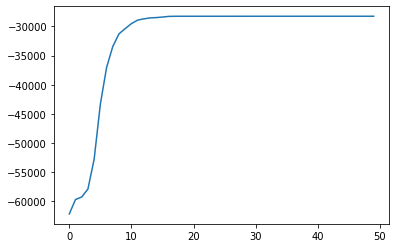

In [109]:
plt.plot(l1)

In [ ]:
A_rand = rand_prob_mat((nstates,nstates))
B_rand = rand_prob_mat((nstates,nobs))
pi_rand = rand_prob_mat((nstates,))
t_HMM = [A_rand, B_rand, pi_rand]
test_HMM = baum_welsch(t_HMM, c_obs_dict['wave'][0], 50) #train HMM

### Pickle HMMs for later use

In [ ]:
#store trained HMMs in pkl because they take forever to train
fname = 'HMMs.pkl'
f = open(fname,'wb')
pkl.dump(HMMs,f)
f.close()

In [ ]:
#Read pickled HMM file to avoid retraining models
fname = 'HMMs.pkl'
f = open(fname,'rb')
HMMs = pkl.load(f)
f.close

## Predict Gestures

In [105]:
def obs_mod_lik(HMM, obs): #likelihood that given observations came from given HMM
    K = len(obs) #number of observations
    A, B, pi = HMM
    _, c = forward_filt(A, B, pi, obs) #forward filter
    lik = -np.sum(np.log(c)) #calculate likelihood of seeing these obs under this HMM
    return lik

In [106]:
def classify_gesture(HMMs, obs):
    keys = np.array(list(HMMs.keys()))
    l = np.zeros(len(keys))
    max_l = 0
    pred = 'none'
    for i,k in enumerate(keys):
        c_obs = kmeans[k].predict(obs)
        l[i] = obs_mod_lik(HMMs[k], c_obs)
    # arrange likelihoods and keys in descending order
    sort_ind = l.argsort()
    sorted_l = l[sort_ind[::-1]]
    sorted_keys = keys[sort_ind[::-1]]
    return [sorted_keys,sorted_l] #returns gestures in order of decreasing likelihood and associated likelihoods

# Predict On Test Data

In [107]:
TEST_DIR_PATH = '../old_test/'
test_files = listdir(TEST_DIR_PATH)

for f in test_files:
    obs = np.genfromtxt(fname=TEST_DIR_PATH + f, usecols=[1,2,3,4,5,6]) #read observations from file
    pred,ls = classify_gesture(HMMs, obs)
    print('----',f,'----')
    for i in range(3):
        print(i+1, '. ', pred[i], '\t', ls[i], sep='')
    print()

---- beat3_31.txt ----
1. eight	-1596.4385393781808
2. beat3	-2324.7594318705765
3. circle	-2358.527285772966

---- beat4_31.txt ----
1. beat4	-1743.8516013824674
2. wave	-2588.956648274954
3. eight	-2763.734470172414

---- circle31.txt ----
1. eight	-1815.2302756334925
2. circle	-1934.5662183273448
3. wave	-2328.7078089731654

---- eight31.txt ----
1. eight	-2417.2858293511745
2. circle	-2934.419318672095
3. beat3	-3417.0296083565313

---- inf31.txt ----
1. circle	-2869.4251175795707
2. eight	-3120.0847966749843
3. inf	-3216.1204141668536

---- wave31.txt ----
1. eight	-1152.1000757232023
2. beat3	-1937.7729415637018
3. circle	-1957.4943214439595

